## Task 4 >> (imagine opening and closing both fists or both feet) ---> subject_id [6,10,14] 


In [83]:
import mne
import numpy as np
import os
from lpt import LPT
import matplotlib.pyplot as plt
import pywt
from glob import glob
from mne.io import concatenate_raws
from sklearn.decomposition import FastICA
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Flatten, Dropout, Permute, Conv1D, BatchNormalization, Activation, AveragePooling2D, Reshape, MaxPooling1D,Conv2D, MaxPooling2D
from sklearn.metrics import cohen_kappa_score, f1_score, precision_score, recall_score, confusion_matrix

In [84]:
all_paths = glob(os.path.join('data', '**', '*.edf'), recursive=True)

In [85]:
import random # Shuffle the list in-place
random.seed(1)
task4_06_paths = [path for path in all_paths if '06' in path.split('\\')[2][5:7]]
random.shuffle(task4_06_paths)
task4_06_paths= task4_06_paths[:105]
task4_10_paths = [path for path in all_paths if '10' in path.split('\\')[2][5:7]]
random.shuffle(task4_10_paths)
task4_10_paths= task4_10_paths[:105]
task4_14_paths = [path for path in all_paths if '14' in path.split('\\')[2][5:7]]
random.shuffle(task4_14_paths)
task4_14_paths= task4_14_paths[:105]

In [86]:
task4_paths = task4_06_paths + task4_10_paths + task4_14_paths
len(task4_paths)

315

In [87]:
%%capture  
# Load each of the files
parts = [mne.io.read_raw_edf(path, preload=True,stim_channel='auto',verbose='WARNING')
        for path in task4_paths]

In [88]:
parts = [part.resample(sfreq=128) for part in parts]

Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.
Sampling frequency of the instance is already 128.0, returning unmodified.


In [7]:
parts[0]

<RawEDF | S025R06.edf, 64 x 15744 (123.0 s), ~7.8 MB, data loaded>

In [89]:
# Concatenate them
raw = concatenate_raws(parts, preload=True)

# Find the events in this dataset
events, _ = mne.events_from_annotations(raw) 

# Use only EEG channels
eeg_channel_inds = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                    exclude='bads')

Used Annotations descriptions: ['T0', 'T1', 'T2']


In [9]:
raw.get_data().shape

(64, 4978560)

In [13]:
raw.get_data().shape

(64, 4977664)

In [90]:
epoched = mne.Epochs(raw, events, dict(left=2, right=3),tmin=-0.5, tmax=0.5,  proj=False, picks=eeg_channel_inds, preload=True)
# tmin=-0.5, tmax=0.5,

Not setting metadata
4743 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 4743 events and 129 original time points ...
0 bad epochs dropped


In [91]:
epoched.equalize_event_counts(dict(left=2, right=3))

Dropped 15 epochs: 242, 253, 270, 435, 458, 463, 482, 499, 604, 617, 754, 767, 1024, 4143, 4160


(<Epochs |  4728 events (all good), -0.5 – 0.5 s, baseline -0.5 – 0 s, ~297.9 MB, data loaded,
  'left': 2364
  'right': 2364>,
 array([ 242,  253,  270,  435,  458,  463,  482,  499,  604,  617,  754,
         767, 1024, 4143, 4160], dtype=int64))

In [92]:
# Pytorch expects float32 for input and int64 for labels.
X = (epoched.get_data()*1e6).astype(np.float32)
y = (epoched.events[:,2]- 2 ).astype(np.int64) # this convert the labels left=2 and right=3 to 0 and 1 respectively


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from mne.decoding import (
    SlidingEstimator,
    GeneralizingEstimator,
    Scaler,
    cross_val_multiscore,
    LinearModel,
    get_coef,
    Vectorizer,
    CSP,
)

csp = CSP(n_components=3, norm_trace=False)
clf_csp = make_pipeline(csp, LinearModel(LogisticRegression(solver="liblinear")))
scores = cross_val_multiscore(clf_csp, epoched.get_data(), epoched.events[:,2]- 2 , cv=5, n_jobs=None)
print("CSP: %0.1f%%" % (100 * scores.mean(),))

In [93]:
from sklearn.preprocessing import normalize

for i in range(X.shape[0]):

    X[i] = normalize(X[i], axis=0, norm = 'max')
X= (X+1)/2

In [75]:
np.max(X[0,:]), np.min(X[0,:])

(1.0, 0.0)

In [94]:
X_t = np.transpose(X, (0, 2, 1))
X_t.shape

(4728, 129, 64)

In [62]:
def modify_y(X):
    num_samples, seq_len, features = X.shape

    # Randomly select a cut length between 1 and max_cut_length
    cut_length = seq_len//11
    new_seq_len = seq_len - 2* cut_length
    # Create an array to store the modified data
    modified_data = np.empty((num_samples, new_seq_len, features))
    # print(modified_data.shape)
    # Loop through each sample and apply the random cut
    for i in range(num_samples):
        cut_start = cut_length
        cut_end = cut_start + new_seq_len
        # print(cut_length, cut_start, cut_end)

        modified_data[i] = X[i, cut_start:cut_end, :]
        
    return modified_data

In [63]:
# Define the parameters
def modify_x(X):
    num_samples, seq_len, features = X.shape

    # Randomly select a cut length between 1 and max_cut_length
    cut_length = seq_len//11
    new_seq_len = seq_len - 2* cut_length
    # Create an array to store the modified data
    modified_data = np.empty((num_samples, new_seq_len, features))
    # print(modified_data.shape)
    # Loop through each sample and apply the random cut
    for i in range(num_samples):
        cut_start = np.random.randint(0, cut_length )
        cut_end = cut_start + new_seq_len
        # print(cut_length, cut_start, cut_end)

        modified_data[i] = X[i, cut_start:cut_end, :]
        
    return modified_data

In [18]:
modified_data.shape

(4740, 97, 64)

In [95]:
# Split the data randomly into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X_t, y, test_size=0.20, random_state=135)

In [98]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

tf.random.set_seed(42)
# Define the LSTM model
model = keras.Sequential([
    layers.LSTM(32, recurrent_dropout=0.2, return_sequences=True,input_shape=(x_train.shape[1], x_train.shape[2])),  # LSTM layer with 128 units
    layers.Dropout(0.4),  # Dropout layer for regularization
    layers.LSTM(32, recurrent_dropout=0.2, return_sequences=True),  # LSTM layer with 64 units
    layers.Flatten(),
    layers.Dropout(0.25),  # Dropout layer for regularization
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification (adjust as needed)
])

optimizer = Adam(learning_rate=0.0005)

# Compile the model
model.compile(optimizer=optimizer, 
              loss='binary_crossentropy',  
              metrics=['accuracy']) 
# epochs_no= 40
# for epoch in range(epochs_no):
history_dnn = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_test, y_test))


Epoch 1/25
119/119 [==============================] - 49s 361ms/step - loss: 0.6563 - accuracy: 0.6161 - val_loss: 0.6189 - val_accuracy: 0.6522
Epoch 2/25
119/119 [==============================] - 39s 329ms/step - loss: 0.6132 - accuracy: 0.6732 - val_loss: 0.6143 - val_accuracy: 0.6702
Epoch 3/25
119/119 [==============================] - 40s 335ms/step - loss: 0.6038 - accuracy: 0.6822 - val_loss: 0.5974 - val_accuracy: 0.6871
Epoch 4/25
119/119 [==============================] - 40s 338ms/step - loss: 0.5850 - accuracy: 0.6983 - val_loss: 0.5911 - val_accuracy: 0.6829
Epoch 5/25
119/119 [==============================] - 40s 334ms/step - loss: 0.5684 - accuracy: 0.7107 - val_loss: 0.5866 - val_accuracy: 0.7040
Epoch 6/25
119/119 [==============================] - 40s 338ms/step - loss: 0.5594 - accuracy: 0.7102 - val_loss: 0.5750 - val_accuracy: 0.7104
Epoch 7/25
119/119 [==============================] - 40s 340ms/step - loss: 0.5511 - accuracy: 0.7271 - val_loss: 0.5751 - val_ac

30/30 [==============================] - 2s 60ms/step - loss: 0.5763 - accuracy: 0.7104
Test accuracy: 0.7103593945503235
Kappa: 0.4203457298119283
F1 Score: 0.7008733624454148
Precision: 0.7149220489977728
Recall: 0.6873661670235546


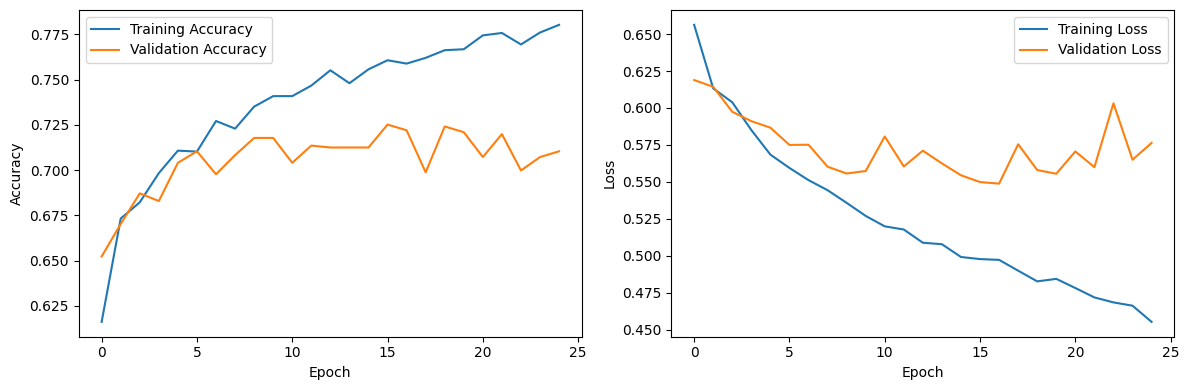

In [99]:
# Calculate additional metrics
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int)

kappa = cohen_kappa_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy:", test_acc)
print("Kappa:", kappa)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_dnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_dnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dnn.history['loss'], label='Training Loss')
plt.plot(history_dnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

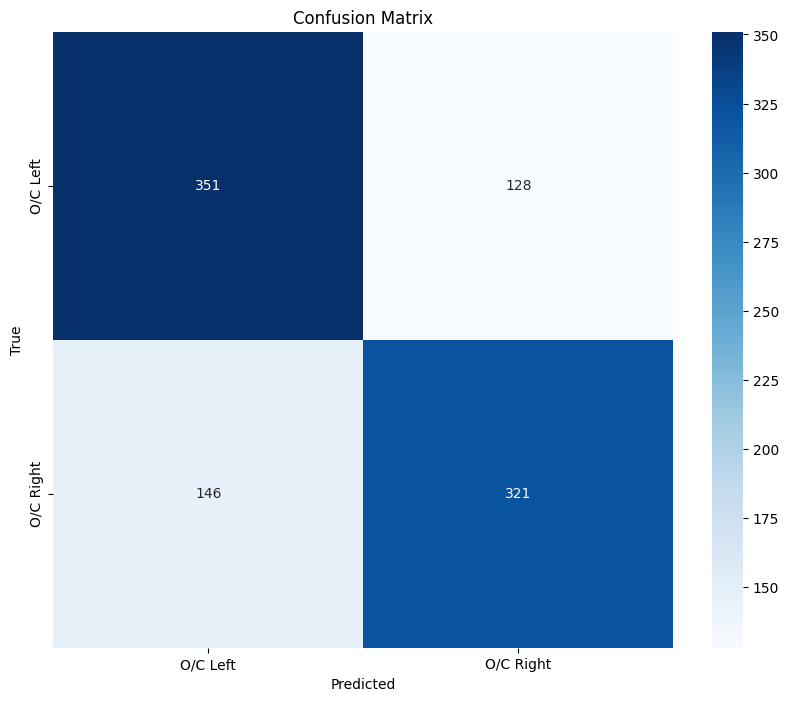

In [100]:
import seaborn as sns

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Define class labels if you have them
class_labels = ["O/C Left", "O/C Right"]

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [101]:
# Define a function to add positional encoding
def positional_encoding(seq_length, d_model):
    position = np.arange(seq_length)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pos_enc = np.zeros((seq_length, d_model))
    pos_enc[:, 0::2] = np.sin(position * div_term)
    pos_enc[:, 1::2] = np.cos(position * div_term)
    pos_enc = pos_enc[np.newaxis, ...]
    return tf.convert_to_tensor(pos_enc, dtype=tf.float32)

In [102]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model

# Define input shape for your EEG data
input_shape=(x_train.shape[1], x_train.shape[2])

# Create an input layer
input_layer = Input(shape=input_shape)

# Add positional encoding to the input
position_encoding_layer = positional_encoding(input_shape[0], input_shape[1])
input_with_position = input_layer + position_encoding_layer

# Multi-head self-attention layer
attention_layer = MultiHeadAttention(num_heads=4, key_dim=32)(input_with_position, input_with_position)

# Layer normalization
normalized_layer = LayerNormalization(epsilon=1e-6)(attention_layer)

# Global average pooling to obtain a fixed-size representation
global_avg_pooling = tf.keras.layers.GlobalAveragePooling1D()(normalized_layer)

# Add a dropout layer for regularization
dropout_layer = Dropout(0.4)(global_avg_pooling)

# Output layer for EEG signal classification
num_classes = 1  # Change this to your number of classes
output_layer = Dense(num_classes, activation='sigmoid')(dropout_layer)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)
opt = Adam(learning_rate=0.0005)

# Compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 129, 64)]            0         []                            
                                                                                                  
 tf.__operators__.add_1 (TF  (None, 129, 64)              0         ['input_3[0][0]']             
 OpLambda)                                                                                        
                                                                                                  
 multi_head_attention_1 (Mu  (None, 129, 64)              33216     ['tf.__operators__.add_1[0][0]
 ltiHeadAttention)                                                  ',                            
                                                                     'tf.__operators__.add_1

In [103]:
history_transformer = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/20
119/119 [==============================] - 19s 140ms/step - loss: 0.7405 - accuracy: 0.5267 - val_loss: 0.6759 - val_accuracy: 0.5729
Epoch 2/20
119/119 [==============================] - 16s 133ms/step - loss: 0.6786 - accuracy: 0.5875 - val_loss: 0.6775 - val_accuracy: 0.5867
Epoch 3/20
119/119 [==============================] - 15s 129ms/step - loss: 0.6626 - accuracy: 0.6079 - val_loss: 0.6477 - val_accuracy: 0.6533
Epoch 4/20
119/119 [==============================] - 16s 134ms/step - loss: 0.6474 - accuracy: 0.6378 - val_loss: 0.6474 - val_accuracy: 0.6332
Epoch 5/20
119/119 [==============================] - 15s 129ms/step - loss: 0.6351 - accuracy: 0.6518 - val_loss: 0.6481 - val_accuracy: 0.6374
Epoch 6/20
119/119 [==============================] - 16s 131ms/step - loss: 0.6252 - accuracy: 0.6605 - val_loss: 0.6314 - val_accuracy: 0.6438
Epoch 7/20
119/119 [==============================] - 15s 124ms/step - loss: 0.6200 - accuracy: 0.6573 - val_loss: 0.6461 - val_ac

 1/30 [>.............................] - ETA: 2s - loss: 0.5714 - accuracy: 0.7812

C:\Users\Ahmed\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


30/30 [==============================] - 1s 46ms/step - loss: 0.5912 - accuracy: 0.6945
Test accuracy: 0.6945031881332397
Kappa: 0.0
F1 Score: 0.3404042876747896
Precision: 0.2563827219537923


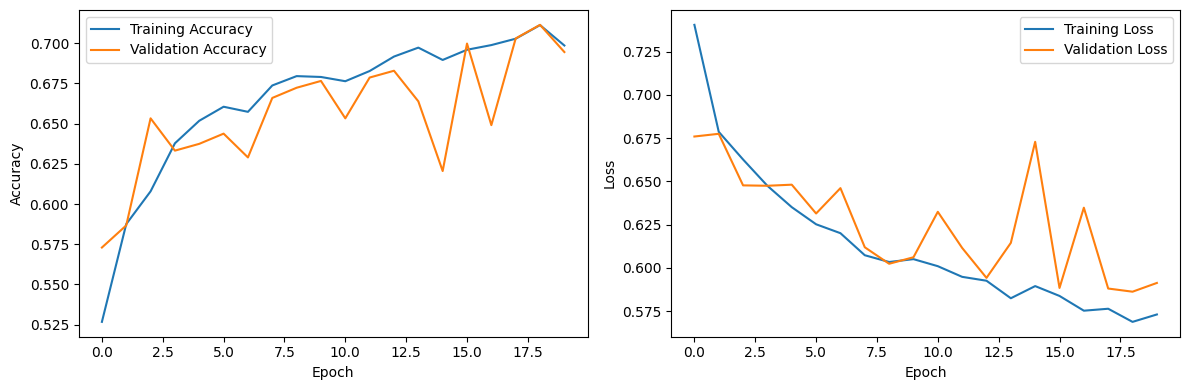

In [104]:
# Calculate additional metrics
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
# y_test_int = np.argmax(y_test, axis=1)

kappa = cohen_kappa_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes, average='weighted')
precision = precision_score(y_test, y_pred_classes, average='weighted')


# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)
print("Kappa:", kappa)
print("F1 Score:", f1)
print("Precision:", precision)

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_transformer.history['accuracy'], label='Training Accuracy')
plt.plot(history_transformer.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_transformer.history['loss'], label='Training Loss')
plt.plot(history_transformer.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

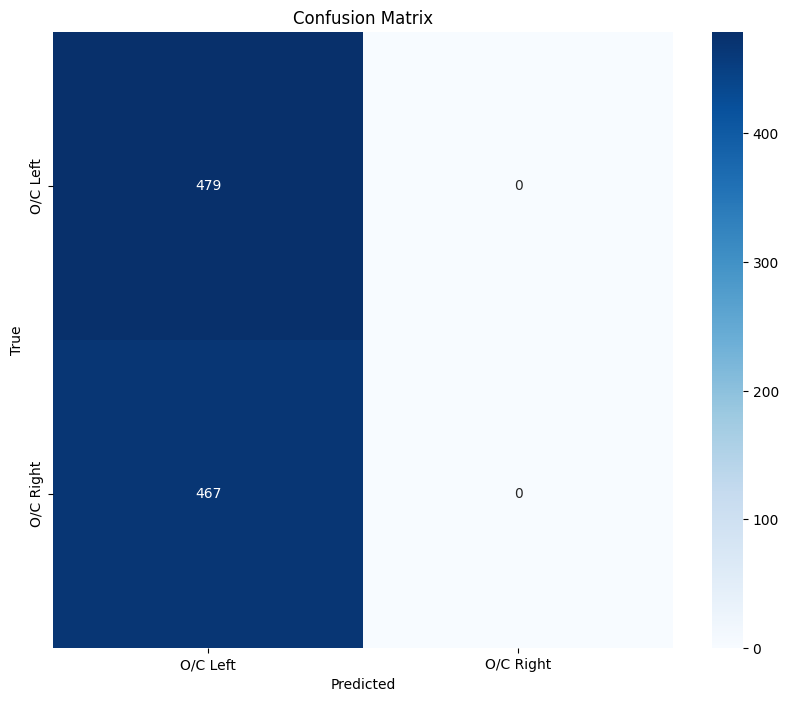

In [105]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Define class labels if you have them
class_labels = ["O/C Left", "O/C Right"]

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [20]:
num_samples = X.shape[0]
num_channels = 25 # reduce the channels numbers from 64 to 25
signal_length = X.shape[2]

# Reshape EEG data for preprocessing
reshaped_data = X.reshape(num_samples, -1)

# Apply ICA
ica = FastICA(n_components=num_channels, random_state=0)
ica_result = ica.fit_transform(reshaped_data)

# Apply SOBI
cov_matrix = np.cov(ica_result, rowvar=False)
eigenvalues, eigenvectors = eigh(cov_matrix)
sobi_result = np.dot(ica_result, eigenvectors)

C:\Users\Ahmed\AppData\Roaming\Python\Python38\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


In [21]:
# Apply CWT (using PyWavelets library)
def apply_cwt(signal):
    wavelet = 'morl'  # Morlet wavelet
    scales = np.arange(1, 51)  # Adjust the scales based on your data
    cwt_result, _ = pywt.cwt(signal, scales, wavelet)
    return cwt_result

# Apply CWT to each sample in the SOBI result
cwt_results = np.array([apply_cwt(sample) for sample in sobi_result])

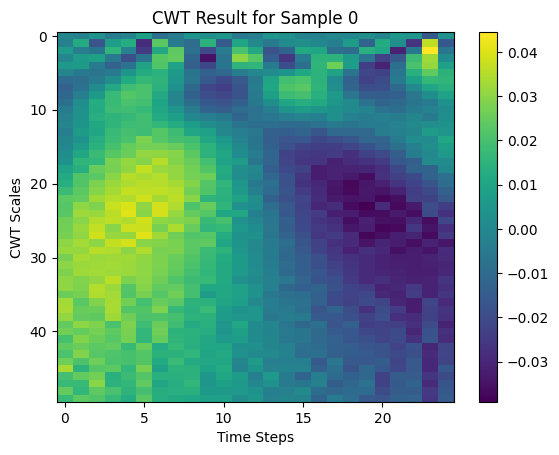

In [22]:
# Visualize an example CWT result
sample_index = 0
plt.imshow(cwt_results[sample_index], aspect='auto', cmap='viridis')
plt.title('CWT Result for Sample {}'.format(sample_index))
plt.xlabel('Time Steps')
plt.ylabel('CWT Scales')
plt.colorbar()
plt.show()

In [23]:
cwt_results.shape, sobi_result.shape, ica_result.shape

((3590, 50, 25), (3590, 25), (3590, 25))

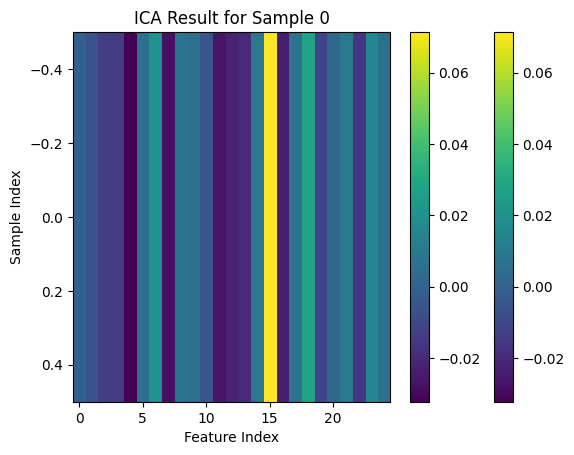

In [24]:
# Create a heatmap-style plot
sample_index = 0
plt.imshow(ica_result[sample_index:1], aspect='auto', cmap='viridis')
plt.colorbar()  # Add a colorbar for reference
plt.title('ICA Result for Sample {}'.format(sample_index))
plt.xlabel("Feature Index")
plt.ylabel("Sample Index")
plt.colorbar()
plt.show()


In [25]:
def local_binary_count(pixel_values, center_value):
    binary_values = (pixel_values >= center_value).astype(int)
    decimal_values = np.sum(binary_values * 2**np.arange(len(pixel_values)))
    return decimal_values

def local_neighbor_descriptive_count(pixel_values):
    binary_values = (pixel_values[:-1] >= pixel_values[1:]).astype(int)
    decimal_values = np.sum(binary_values * 2**(len(pixel_values)-2 - np.arange(len(binary_values))))
    return decimal_values

def local_gradient_count(pixel_values, center_value):
    gradient_values = np.abs(pixel_values - center_value)
    average_gradient = np.mean(gradient_values)
    binary_values = (gradient_values >= average_gradient).astype(int)
    decimal_value = np.sum(binary_values * 2**np.arange(len(pixel_values)))
    return decimal_value

In [26]:
# Applying transformations to the CWT output
transformed_output = np.zeros((cwt_results.shape[0], cwt_results.shape[1], cwt_results.shape[2], 3), dtype=int)  # Create an array to store the transformed values

for i in range(cwt_results.shape[0]):
    for j in range(cwt_results.shape[1]):
        for k in range(cwt_results.shape[2]):
            pixel_values = cwt_results[i, j, :]
            center_value = pixel_values[k]

            lbc_decimal = local_binary_count(pixel_values, center_value)
            lndc_decimal = local_neighbor_descriptive_count(pixel_values)
            lgc_decimal = local_gradient_count(pixel_values, center_value)

            transformed_output[i, j, k] = [lbc_decimal, lndc_decimal, lgc_decimal]

In [27]:
transformed_output.shape

(3590, 50, 25, 3)

the label of Sample 100 = 1


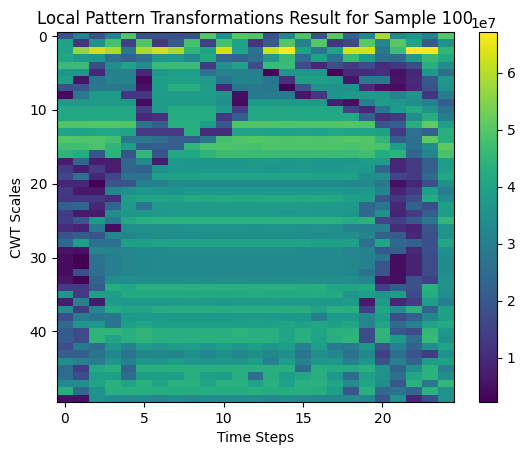

In [28]:
# Choose an index for each technique
lbc_index = 0
lndc_index = 1
lgc_index = 2

combined_transform = (
    transformed_output[:, :, :, lbc_index] +
    transformed_output[:, :, :, lndc_index] +
    transformed_output[:, :, :, lgc_index]
)
# Visualize an example CWT result
sample_index = 100
print(f'the label of Sample {sample_index} = {y[sample_index]}')
plt.imshow(combined_transform[sample_index], aspect='auto', cmap='viridis')
plt.title('Local Pattern Transformations Result for Sample {}'.format(sample_index))
plt.xlabel('Time Steps')
plt.ylabel('CWT Scales')
plt.colorbar()
plt.show()

In [339]:
x_train, x_test, y_train, y_test = train_test_split(X_t, y, test_size=0.20, random_state=1235)

In [107]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(64, recurrent_dropout=0.25, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(layers.Dropout(0.45))
model.add(LSTM(32, recurrent_dropout=0.25, return_sequences=True))
model.add(layers.Dropout(0.4))
model.add(LSTM(32,  return_sequences=True))
model.add(Flatten())
# model.add(Dense(16, activation='relu')) 
model.add(layers.Dropout(0.45))
model.add(Dense(8, activation='relu')) 
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/20
119/119 [==============================] - 52s 382ms/step - loss: 0.6945 - accuracy: 0.4971 - val_loss: 0.6932 - val_accuracy: 0.4937
Epoch 2/20
119/119 [==============================] - 37s 315ms/step - loss: 0.6932 - accuracy: 0.4894 - val_loss: 0.6932 - val_accuracy: 0.4937
Epoch 3/20
119/119 [==============================] - 38s 322ms/step - loss: 0.6932 - accuracy: 0.5016 - val_loss: 0.6932 - val_accuracy: 0.4937
Epoch 4/20
119/119 [==============================] - 38s 321ms/step - loss: 0.6916 - accuracy: 0.5280 - val_loss: 0.6931 - val_accuracy: 0.5063
Epoch 5/20
119/119 [==============================] - 39s 324ms/step - loss: 0.6933 - accuracy: 0.4984 - val_loss: 0.6931 - val_accuracy: 0.5063
Epoch 6/20
119/119 [==============================] - 37s 315ms/step - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0.6931 - val_accuracy: 0.5063
Epoch 7/20
119/119 [==============================] - 38s 322ms/step - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0.6931 - val_ac

In [ ]:
# Calculate additional metrics
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int)

kappa = cohen_kappa_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

26/26 [==============================] - 6s 228ms/step - loss: 0.6486 - accuracy: 0.6313


Test accuracy: 0.6313253045082092
Kappa: 0.25881611355597844
F1 Score: 0.6561797752808989
Precision: 0.6517857142857143
Recall: 0.6606334841628959


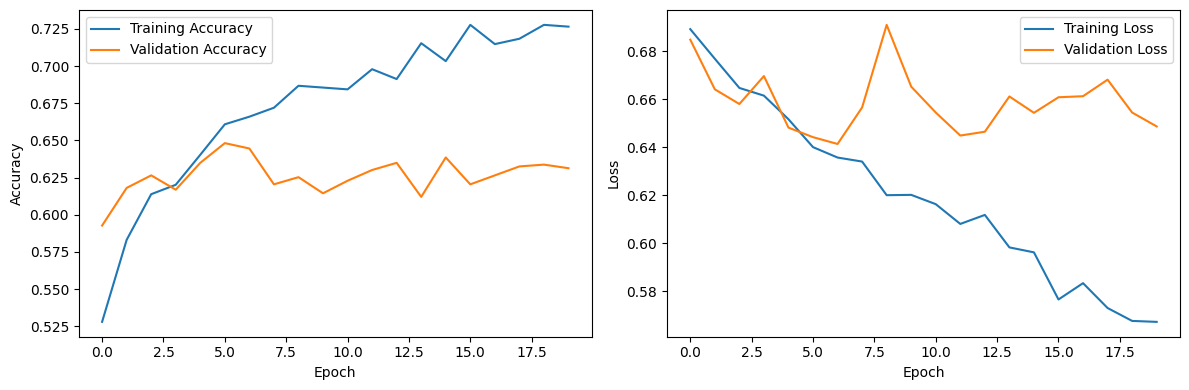

In [ ]:
print("Test accuracy:", test_acc)
print("Kappa:", kappa)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [109]:
# Define the Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(32, recurrent_dropout=0.2, return_sequences=True), input_shape=(x_train.shape[1], x_train.shape[2])))
# model.add(layers.Dropout(0.55))
# model.add(Bidirectional(LSTM(64, recurrent_dropout=0.4, return_sequences=True)))
model.add(layers.Dropout(0.45))
model.add(Bidirectional(LSTM(32, recurrent_dropout=0.3, return_sequences=True)))
model.add(Flatten())
model.add(layers.Dropout(0.25))
model.add(Dense(8, activation='relu')) 
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_Bi = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test))


Epoch 1/20
119/119 [==============================] - 45s 288ms/step - loss: 0.6475 - accuracy: 0.6177 - val_loss: 0.6149 - val_accuracy: 0.6839
Epoch 2/20
119/119 [==============================] - 33s 273ms/step - loss: 0.6009 - accuracy: 0.6809 - val_loss: 0.6036 - val_accuracy: 0.6776
Epoch 3/20
119/119 [==============================] - 33s 281ms/step - loss: 0.5941 - accuracy: 0.6920 - val_loss: 0.5774 - val_accuracy: 0.6934
Epoch 4/20
119/119 [==============================] - 34s 289ms/step - loss: 0.5719 - accuracy: 0.7081 - val_loss: 0.5842 - val_accuracy: 0.6903
Epoch 5/20
119/119 [==============================] - 34s 286ms/step - loss: 0.5651 - accuracy: 0.7158 - val_loss: 0.5821 - val_accuracy: 0.7114
Epoch 6/20
119/119 [==============================] - 34s 287ms/step - loss: 0.5556 - accuracy: 0.7179 - val_loss: 0.6326 - val_accuracy: 0.6406
Epoch 7/20
119/119 [==============================] - 35s 293ms/step - loss: 0.5494 - accuracy: 0.7298 - val_loss: 0.5748 - val_ac

30/30 [==============================] - 2s 52ms/step - loss: 0.5559 - accuracy: 0.7093
Test accuracy: 0.7093023061752319
Kappa: 0.41874494487963787
F1 Score: 0.7102212855637513
Precision: 0.6991701244813278
Recall: 0.721627408993576


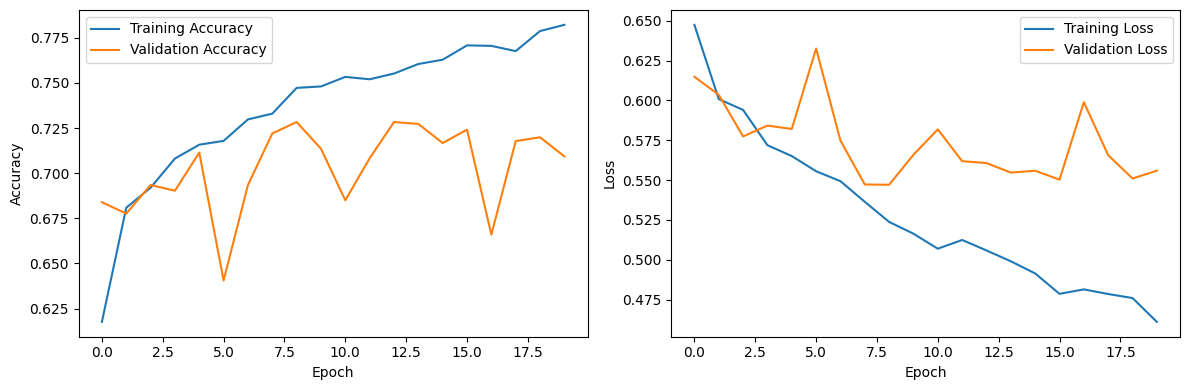

In [110]:
# Calculate additional metrics
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int)

kappa = cohen_kappa_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy:", test_acc)
print("Kappa:", kappa)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_Bi.history['accuracy'], label='Training Accuracy')
plt.plot(history_Bi.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_Bi.history['loss'], label='Training Loss')
plt.plot(history_Bi.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Define the Deep Neural Network (DNN) model
model = Sequential()
model.add(Flatten(input_shape=(x_train.shape[1], x_train.shape[2])))  # Flatten the CWT data
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))  # Dropout for regularization
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))  # Dropout for regularization
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_dnn = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
104/104 [==============================] - 7s 42ms/step - loss: 36.9886 - accuracy: 0.5593 - val_loss: 26.6792 - val_accuracy: 0.5964
Epoch 2/50
104/104 [==============================] - 4s 35ms/step - loss: 20.4468 - accuracy: 0.5627 - val_loss: 10.7138 - val_accuracy: 0.5880
Epoch 3/50
104/104 [==============================] - 4s 34ms/step - loss: 14.2195 - accuracy: 0.5627 - val_loss: 4.1858 - val_accuracy: 0.5313
Epoch 4/50
104/104 [==============================] - 4s 36ms/step - loss: 8.0912 - accuracy: 0.5630 - val_loss: 2.5559 - val_accuracy: 0.5904
Epoch 5/50
104/104 [==============================] - 4s 40ms/step - loss: 5.4113 - accuracy: 0.5657 - val_loss: 1.6737 - val_accuracy: 0.5807
Epoch 6/50
104/104 [==============================] - 4s 40ms/step - loss: 3.8157 - accuracy: 0.5539 - val_loss: 1.5765 - val_accuracy: 0.4964
Epoch 7/50
104/104 [==============================] - 5s 44ms/step - loss: 2.6717 - accuracy: 0.5383 - val_loss: 1.0464 - val_accuracy: 0

26/26 [==============================] - 0s 14ms/step - loss: 0.6657 - accuracy: 0.5759
Test accuracy: 0.575903594493866
Kappa: 0.17996160280232165
F1 Score: 0.4482758620689656
Precision: 0.7295918367346939
Recall: 0.3235294117647059


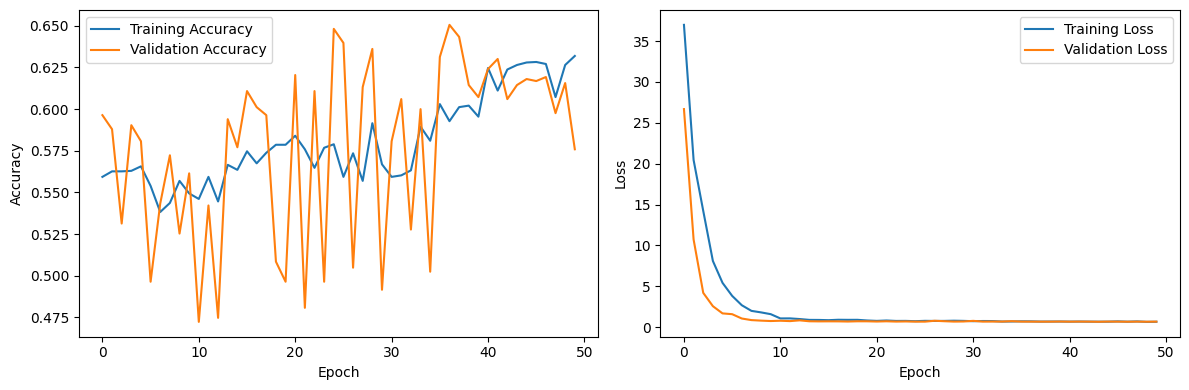

In [ ]:
# Calculate additional metrics
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int)

kappa = cohen_kappa_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy:", test_acc)
print("Kappa:", kappa)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_dnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_dnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dnn.history['loss'], label='Training Loss')
plt.plot(history_dnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X_t, y, test_size=0.2,shuffle=True, random_state=919)

In [116]:
# Define the advanced 1D CNN model
model = Sequential([
    Conv1D(16, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.45),
    Conv1D(32, kernel_size=3, activation='relu'),  # Additional Conv1D layer
    MaxPooling1D(pool_size=2),
    Dropout(0.45),
    Flatten(),
    # Dense(64, activation='relu'),
    # Dropout(0.55),
    Dense(32, activation='relu'),
    Dropout(0.55),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_cnn = model.fit(x_train, y_train, epochs=50, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/50
60/60 [==============================] - 3s 23ms/step - loss: 0.6980 - accuracy: 0.5005 - val_loss: 0.6926 - val_accuracy: 0.5655
Epoch 2/50
60/60 [==============================] - 1s 18ms/step - loss: 0.6909 - accuracy: 0.5288 - val_loss: 0.6886 - val_accuracy: 0.6121
Epoch 3/50
60/60 [==============================] - 1s 18ms/step - loss: 0.6788 - accuracy: 0.5730 - val_loss: 0.6567 - val_accuracy: 0.6342
Epoch 4/50
60/60 [==============================] - 1s 19ms/step - loss: 0.6555 - accuracy: 0.6137 - val_loss: 0.6466 - val_accuracy: 0.6459
Epoch 5/50
60/60 [==============================] - 1s 17ms/step - loss: 0.6615 - accuracy: 0.6155 - val_loss: 0.6473 - val_accuracy: 0.6512
Epoch 6/50
60/60 [==============================] - 1s 17ms/step - loss: 0.6499 - accuracy: 0.6251 - val_loss: 0.6479 - val_accuracy: 0.6596
Epoch 7/50
60/60 [==============================] - 1s 20ms/step - loss: 0.6511 - accuracy: 0.6438 - val_loss: 0.6394 - val_accuracy: 0.6586
Epoch 8/50
60

30/30 [==============================] - 0s 9ms/step - loss: 0.6199 - accuracy: 0.6681
Test accuracy: 0.6680760979652405
Kappa: 0.3375379688399043
F1 Score: 0.6915520628683692
Precision: 0.6388384754990926
Recall: 0.7537473233404711


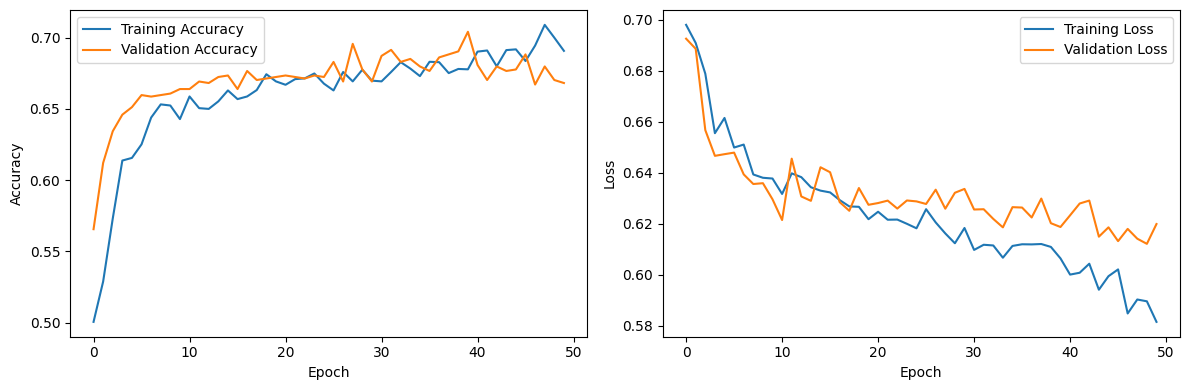

In [117]:
# Calculate additional metrics
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int)

kappa = cohen_kappa_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy:", test_acc)
print("Kappa:", kappa)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

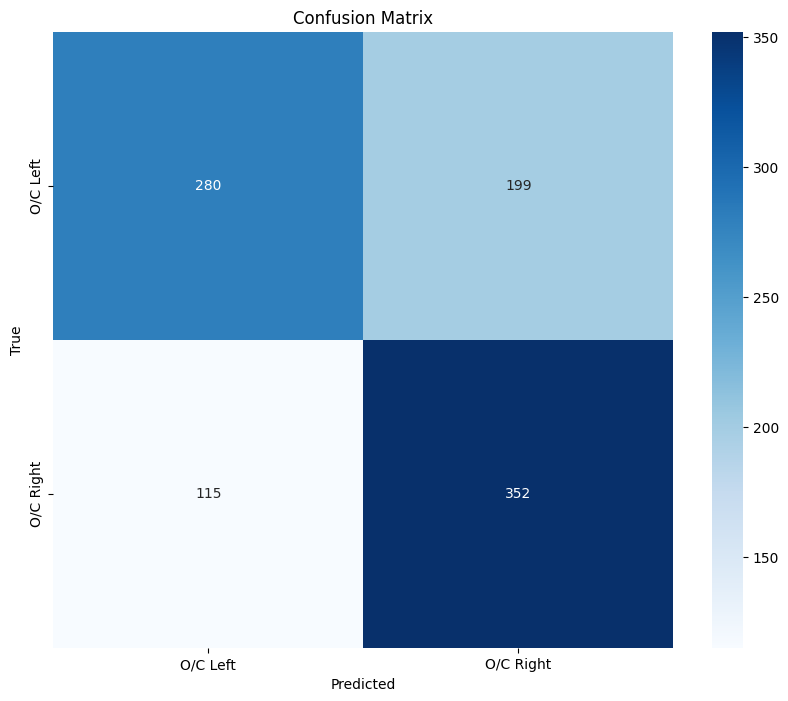

In [118]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Define class labels if you have them
class_labels = ["O/C Left", "O/C Right"]

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [119]:
from tensorflow.keras.layers import GRU
# tensorflow.random.set_seed(42)

# Define the advanced 1D CNN model with a GRU layer
model = Sequential([
    Conv1D(16, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.35),
    Conv1D(32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.35),
    GRU(32,recurrent_dropout=0.25, return_sequences=True),  # Adding a GRU layer with 64 units
    Dropout(0.3),
    Dropout(0.2),
    Flatten(),
    Dense(1, activation='sigmoid')
])

opt = Adam(learning_rate=0.0005)

# Compile the model
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_cnn_gru = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/25
119/119 [==============================] - 16s 97ms/step - loss: 0.6989 - accuracy: 0.5082 - val_loss: 0.6872 - val_accuracy: 0.5867
Epoch 2/25
119/119 [==============================] - 13s 112ms/step - loss: 0.6833 - accuracy: 0.5624 - val_loss: 0.6735 - val_accuracy: 0.6247
Epoch 3/25
119/119 [==============================] - 10s 87ms/step - loss: 0.6648 - accuracy: 0.6121 - val_loss: 0.6507 - val_accuracy: 0.6385
Epoch 4/25
119/119 [==============================] - 10s 88ms/step - loss: 0.6475 - accuracy: 0.6290 - val_loss: 0.6363 - val_accuracy: 0.6712
Epoch 5/25
119/119 [==============================] - 10s 88ms/step - loss: 0.6393 - accuracy: 0.6372 - val_loss: 0.6256 - val_accuracy: 0.6755
Epoch 6/25
119/119 [==============================] - 11s 90ms/step - loss: 0.6297 - accuracy: 0.6523 - val_loss: 0.6267 - val_accuracy: 0.6638
Epoch 7/25
119/119 [==============================] - 12s 100ms/step - loss: 0.6232 - accuracy: 0.6497 - val_loss: 0.6147 - val_accurac

30/30 [==============================] - 0s 7ms/step - loss: 0.5781 - accuracy: 0.7125
Test accuracy: 0.7124735713005066
Kappa: 0.42448411757601245
F1 Score: 0.7010989010989012
Precision: 0.7200902934537246
Recall: 0.683083511777302


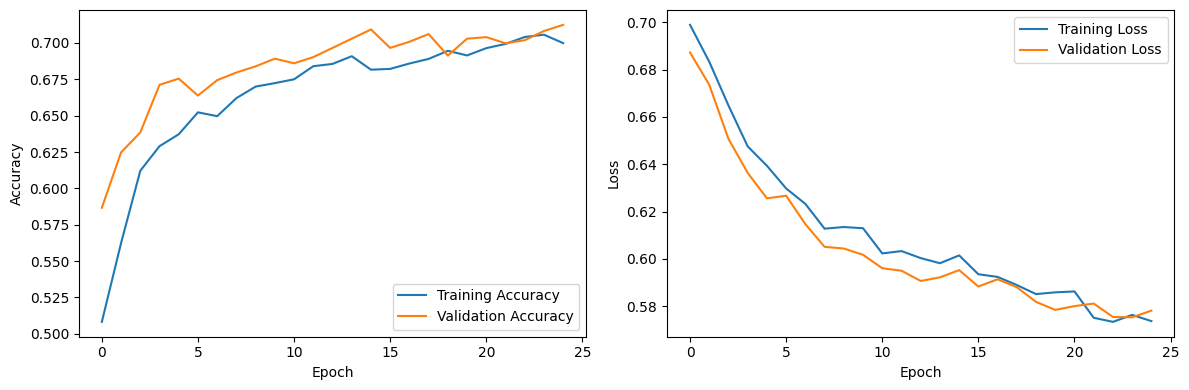

In [120]:
 # Calculate additional metrics
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int)

kappa = cohen_kappa_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy:", test_acc)
print("Kappa:", kappa)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn_gru.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_gru.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_gru.history['loss'], label='Training Loss')
plt.plot(history_cnn_gru.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

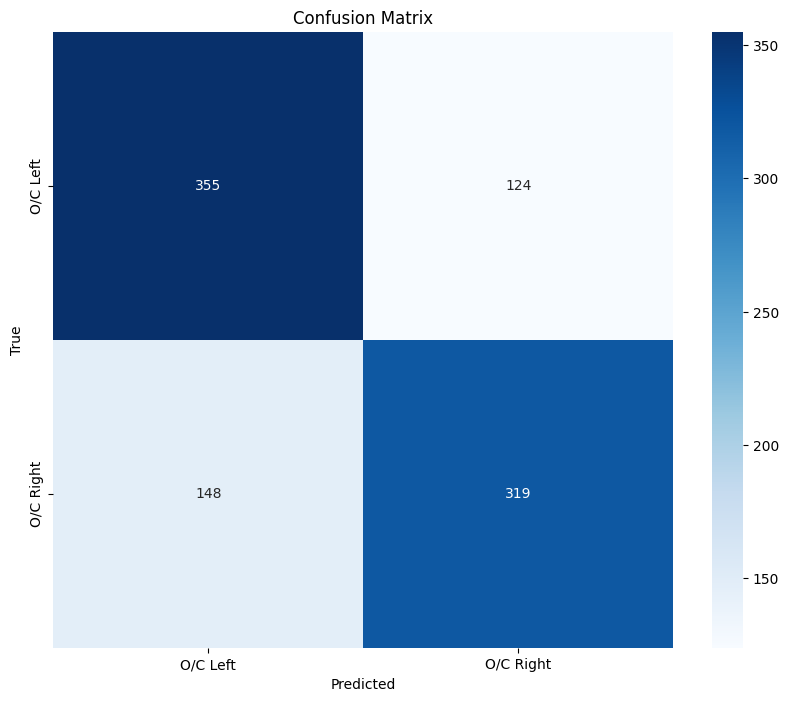

In [121]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Define class labels if you have them
class_labels = ["O/C Left", "O/C Right"]

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()